In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

In [6]:
data = pd.read_csv('../Data/santander-customer-transaction-prediction/train.csv')
data.drop('ID_code', axis=1, inplace=True)
data.head()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,-4.9193,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,-5.8609,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,6.2654,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 201 entries, target to var_199
dtypes: float64(200), int64(1)
memory usage: 306.7 MB


/Users/tongc/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/tongc/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/tongc/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/tongc/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 353, in _score
    y_pred = method_caller(estimator, "predict", X)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/tongc/anaconda3/lib/python

Best Params (No PCA): {'n_neighbors': 7, 'weights': 'distance'}
KNN (No PCA) Results:
Accuracy: 0.89935
Confusion Matrix:
 [[35970    10]
 [ 4016     4]]
Classification Report:
               precision    recall  f1-score   support

           0       0.90      1.00      0.95     35980
           1       0.29      0.00      0.00      4020

    accuracy                           0.90     40000
   macro avg       0.59      0.50      0.47     40000
weighted avg       0.84      0.90      0.85     40000



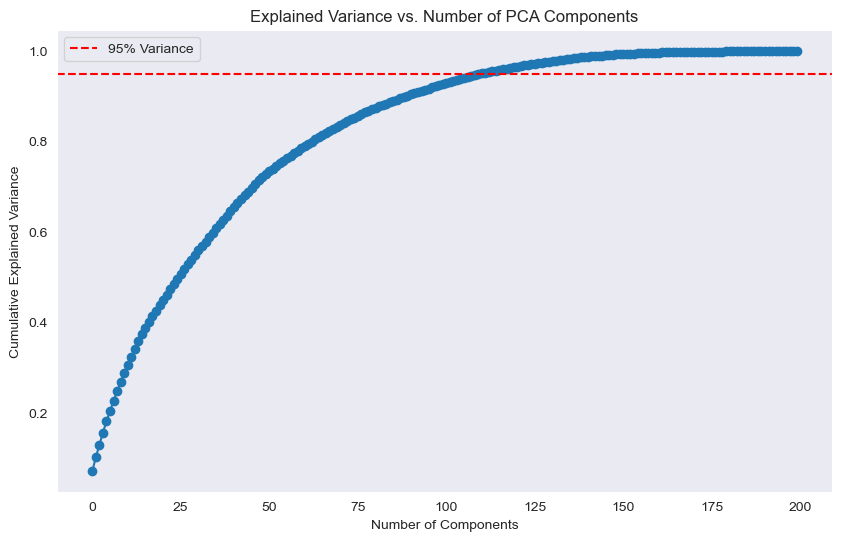

Number of components to retain 95% variance: 111


In [7]:


data.info()
data.isnull().sum()
X = data.drop('target', axis=1)
y = data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train_scaled = X_train
X_test_scaled = X_test
knn = KNeighborsClassifier()
param_grid = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance']
}
# grid_knn = RandomizedSearchCV(knn, param_grid, n_iter=10, cv=5, scoring='accuracy', random_state=42)

grid_knn = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

X_train_small, _, y_train_small, _ = train_test_split(X_train_scaled, y_train, train_size=0.5, random_state=42)
grid_knn.fit(X_train_small, y_train_small)

print("Best Params (No PCA):", grid_knn.best_params_)
knn_best = grid_knn.best_estimator_
y_pred = knn_best.predict(X_test_scaled)
print("KNN (No PCA) Results:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
pca = PCA()
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
var_ratio_cumsum = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(10, 6))
plt.plot(var_ratio_cumsum, marker='o')
plt.axhline(0.95, color='r', linestyle='--', label='95% Variance')
plt.title('Explained Variance vs. Number of PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.legend()
plt.grid()
plt.show()
n_components = np.argmax(var_ratio_cumsum >= 0.95) + 1
print(f"Number of components to retain 95% variance: {n_components}")



In [8]:
pca_optimal = PCA(n_components=n_components)
X_train_pca_optimal = pca_optimal.fit_transform(X_train_scaled)
X_test_pca_optimal = pca_optimal.transform(X_test_scaled)
grid_knn_pca = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_knn_pca.fit(X_train_pca_optimal, y_train)
print("Best Params (With PCA):", grid_knn_pca.best_params_)
knn_pca_best = grid_knn_pca.best_estimator_
y_pred_pca = knn_pca_best.predict(X_test_pca_optimal)
print("\nKNN (With PCA) Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_pca))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_pca))
print("Classification Report:\n", classification_report(y_test, y_pred_pca))
print("\nComparison:")
print(f"Accuracy Without PCA: {accuracy_score(y_test, y_pred)}")
print(f"Accuracy With PCA: {accuracy_score(y_test, y_pred_pca)}")

Best Params (With PCA): {'n_neighbors': 7, 'weights': 'uniform'}

KNN (With PCA) Results:
Accuracy: 0.8992
Confusion Matrix:
 [[35963    17]
 [ 4015     5]]
Classification Report:
               precision    recall  f1-score   support

           0       0.90      1.00      0.95     35980
           1       0.23      0.00      0.00      4020

    accuracy                           0.90     40000
   macro avg       0.56      0.50      0.47     40000
weighted avg       0.83      0.90      0.85     40000


Comparison:
Accuracy Without PCA: 0.89935
Accuracy With PCA: 0.8992
